# Transfer Learning / Feature extraction

## 0. imports and package installation

In [1]:
import requests
from pathlib import Path
import tarfile
import gzip

import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC, LinearSVC
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from keras.datasets import cifar10
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator, array_to_img
from keras.models import Model
from keras.layers import UpSampling2D, Input, GlobalMaxPooling2D, Flatten, ZeroPadding2D
from keras.applications import vgg16, inception_v3

%matplotlib inline

Using TensorFlow backend.


Following line installs opencv on google colab. It is not necessary if you already have opencv installed.

In [0]:
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python

In [0]:
import cv2

In [2]:
!pip install hyperopt

There is an issue with compatibility of hyperopt and networkx 2.x, hence downgrade.

In [3]:
!pip install networkx==1.11

In [0]:
from hyperopt import hp, fmin, STATUS_OK, tpe, Trials, space_eval

## 1. Load dataset

Here are two functions that download CIFAR10 data locally. I have implemented them, but prefer to use data provided by Keras package.

In [0]:
def maybe_download(url):
  """ Downloads file from url, unless file exists """
  filename = url.split('/')[-1]
  local_path = Path(filename)
  
  if not local_path.exists():
    r = requests.get(url)
    with local_path.open('wb') as fp:
      for chunk in r.iter_content(chunk_size=1024 ** 2): 
          if chunk:
              fp.write(chunk)
              
  return local_path

In [0]:
def extract_tgz(local_path):
  """ extracts file, overwrites if necessary. """
  with tarfile.open(str(local_path)) as tar:
    tar.extractall()

In [0]:
local_path = maybe_download("https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz")
extract_tgz(local_path)

Loading CIFAR10 from Keras.

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [6]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

## 2. Visualize dataset

Picking random pics from every class, plotting in a 10x10 matrix.

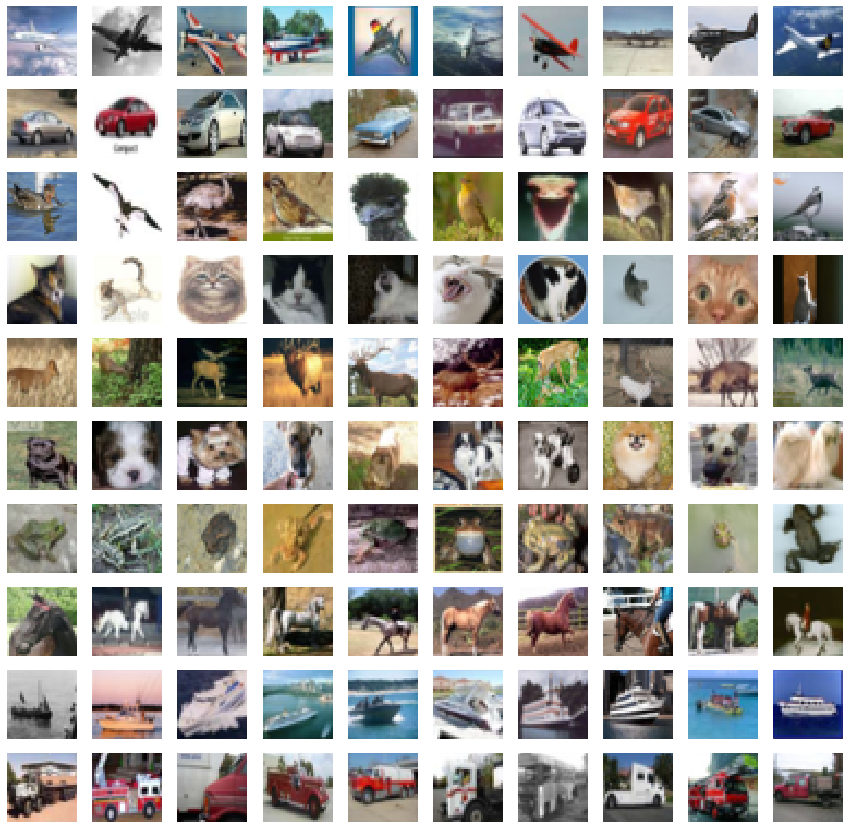

In [11]:
positions = np.reshape(np.arange(len(y_train)), (-1, 1))

plt.figure(figsize=(15, 15))
for i in range(10):
  for j, index in enumerate(np.random.choice(positions[y_train == i], 10, replace=False)):
    plt.subplot(10, 10, i * 10 + (j + 1))
    plt.imshow(x_train[index, :, :, :])
    plt.grid(False)
    plt.tick_params(axis='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')

## 3. Train shallow classifier

I'm using HOG descriptor here from OpenCV to extract features from the images. Parameters for `HOGDescriptior` here are copied from several articles. Perfect way to approach this problem (if we wanted to spend more time, which we probably don't want) would be to:

1. Wrap `HOGDescriptor` in [`sklearn.BaseEstimator`](http://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html#sklearn.base.BaseEstimator), support it with `fit_transform()` method
2. build short pipeline with above estimator and eg. `SVC()`
3. use `hyperopt` for parameter optimization for __both__ `HOGDescriptorEstimator` and `SVC()`

In [0]:
winSize = (20,20)
blockSize = (10,10)
blockStride = (5,5)
cellSize = (10,10)
nbins = 9
derivAperture = 1
winSigma = -1.
histogramNormType = 0
L2HysThreshold = 0.2
gammaCorrection = 1
nlevels = 64

useSignedGradients = True
 
hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins, derivAperture, winSigma,
                        histogramNormType, L2HysThreshold, gammaCorrection, nlevels, useSignedGradients)

In [0]:
descriptor = hog.compute(x_train[0, :, :, :])

In [9]:
x_train.shape

(50000, 32, 32, 3)

In [0]:
x_train_hog = np.zeros((x_train.shape[0], 324))

In [0]:
for i in range(50000):
  x_train_hog[i, :] = hog.compute(x_train[i, :, :, :]).flatten()

In [0]:
x_test_hog = np.zeros((x_test.shape[0], 324))

In [0]:
for i in range(10000):
  x_test_hog[i, :] = hog.compute(x_test[i, :, :, :]).flatten()

In [0]:
clf = SVC()

In [16]:
clf.fit(x_train_hog, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [17]:
clf.score(x_test_hog, y_test)

0.4869

We achieved pretty decent accurracy here - **48.6%** - which is above dummy estimator accuracy - **10%**. We do not have hyperparameter optimization here, but we may achieve only few percent tops and loose a lot of time (or resources (or both)). I'm going to skip that.

## 4. Extract visual features from pretrained network

Biggest problem here is that CIFAR10 has images of size 32x32 and most of the available networks are trained on much bigger resolutions, most of them on IMAGENET that has input size 224x224. Problem is caused by the architectures of convolutional NN, where with each subsequent layer convolutions decrease width and height (whether by strides > 1 or pooling). This means that at certain depth, 32x32 image will be of size 1x1xD (D is arbitrary) and will no longer be able to be squeezed by deeper layers. There are several ways to work with this:

1. upsample image
2. zero pad image
3. remove some initial maxpooling layers (if present)
4. cut some layers at the end of convolutional base (so that dimension sizes are okay)

Another issue is what to do with fully connected layers that are present after the bottleneck (convolutional base) layers. There are often several of the layers, with last being classification layer. However, previous FC layers

1. encode some classification rules for original dataset (IMAGENET) which may yield false results
2. they keep the input image resolution fixed - Without FC layers, we may play with input size as long as conv layer dimensions are correct
3. they destroy spatial information about the image kept in convolutions.

Before however we get to network architectures, we must preprocess input dataset with

1.   standard image preprocessing (eg. rescaling)
2.   pretrained model specific preprocessing



In [0]:
image_gen = ImageDataGenerator(rescale=1./255)

In [0]:
BATCH_SIZE=50

VGG16-specific image data preprocessing.

In [0]:
x_train_pp = vgg16.preprocess_input(x_train.astype('float32'))
x_test_pp = vgg16.preprocess_input(x_test.astype('float32'))

Note `shuffle=False` parameter - this means that data generator will not shuffle samples. This is crucial, because we still want to have mapping to original labels kept in `y_train` and `y_test`. This wouldn't be the case with training, because then training labels are returned in proper order with every sample, but with prediction it only returns samples.

In [0]:
input_train = image_gen.flow(x_train_pp, y_train, batch_size=BATCH_SIZE, shuffle=False)
input_test = image_gen.flow(x_test_pp, y_test, batch_size=BATCH_SIZE, shuffle=False)

Since scikit-learn does not like 2D arrays for labels and gives warning every time, let's flatten them to 1D.

In [11]:
y_train = y_train.flatten()
y_test = y_test.flatten()

y_train.shape, y_test.shape

((50000,), (10000,))

### 4.1 No padding/upsampling on image, no FC layers

At the beginning we will start with VGG16 architecture. When used without FC layers (`include_top=False`), it accepts the 32x32 shape. To achieve 2D tensor on the output, we need to `Flatten()` the resulting conv representation.

In [9]:
conv_base = VGG16(include_top=False, weights='imagenet')

58892288/58889256 [==============================] - 8s 0us/step


In [0]:
input_layer = Input(shape=(32, 32, 3))
x = conv_base(input_layer)
x = Flatten()(x)

model1 = Model(inputs=input_layer, outputs=x)

In [11]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
Total params: 14,714,688
Trainable params: 14,714,688
Non-trainable params: 0
_________________________________________________________________


In [0]:
model1.compile(optimizer='adam', loss='categorical_crossentropy')

In [13]:
feats_train1 = model1.predict_generator(input_train, verbose=1, steps=1000)

1000/1000 [==============================] - 26s 26ms/step


In [14]:
feats_test1 = model1.predict_generator(input_test, verbose=1, steps=200)

200/200 [==============================] - 5s 25ms/step


**Note**: in real life, I would save the output to local file, same with model. Since this takes 26s, it doesn't matter.

In [15]:
feats_train1.shape, feats_test1.shape

((50000, 512), (10000, 512))

Let's now visualize dataset visual vectors. We will use t-SNE visualization technique which has been proven superior over other dimensionality reduction techniques. In short, we're doing reduction of number of dimensions from 512 (in this case) to two dimensions.

Because t-SNE is computationally demanding and plotting 50,000 data point is pointless on so small space, we will randomly choose 2000 datapoints and plot them. Note that in this case we're okay with sampling from data without stratification - since we have perfectly balanced classes, probability of picking any of them from dataset on random is equal, so in resulting dataset we should have more or less equal representations of each class.

In [0]:
def vis_tsne(data, labels, size=2000):
  
  tsne = TSNE(n_components=2, init='pca', random_state=0, verbose=1)
  
  indices = np.random.randint(0, data.shape[0], 2000)
  tsne_data = data[indices, :]
  tsne_labels = labels[indices]
  
  X_tsne = tsne.fit_transform(tsne_data)
  
  plt.figure(figsize=(16, 16))
  plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=tsne_labels.flatten(), cmap=plt.cm.Accent)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.037s...
[t-SNE] Computed neighbors for 2000 samples in 4.060s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 1.781974
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.883644
[t-SNE] Error after 1000 iterations: 2.001663
CPU times: user 48.6 s, sys: 25.8 s, total: 1min 14s
Wall time: 1min 13s


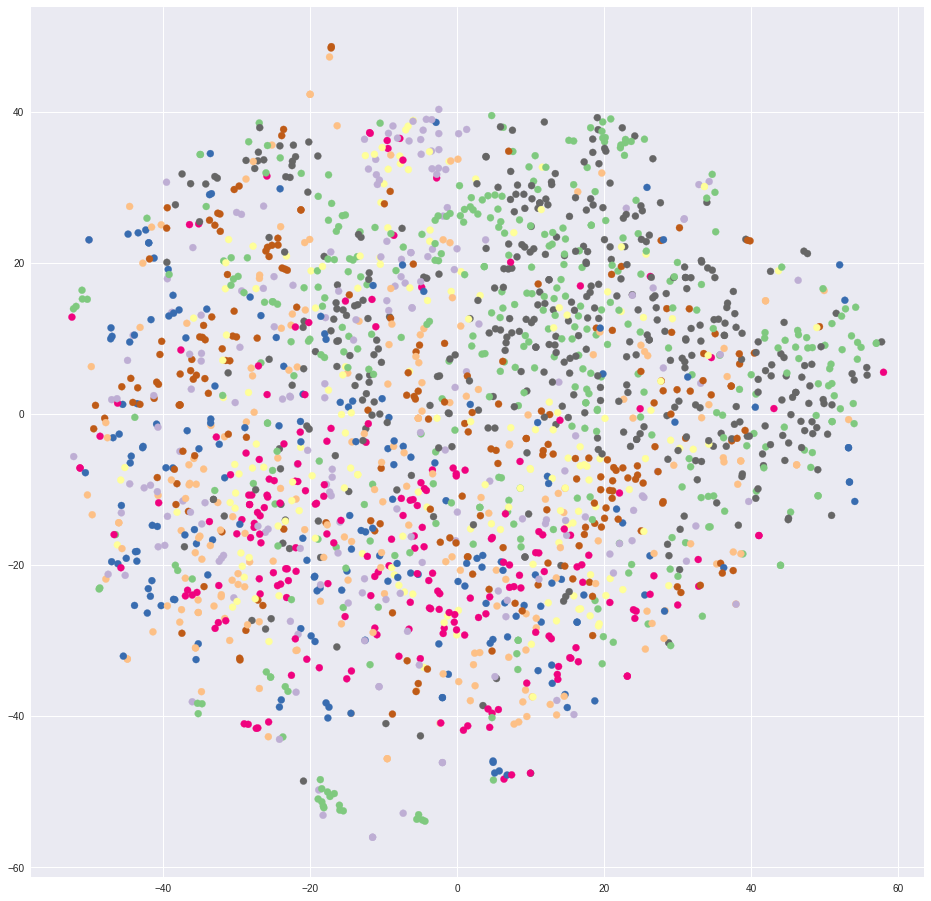

In [22]:
%%time
vis_tsne(feats_train1, y_train)

We can easily spot clusters of colors, but also clusters are heavily overlapping, thus will give lot of noise resulting in average accurracy. Let's confirm it with the model.

**Note**: my approach here is to train simple SVM model (`LinearSVC()`) without non-linear kernel and with default parameters. It will be fast and should give us rough estimate whether this is good way to go or not. Than we may think about hyperparameter optimisation/using non-linear kernel.

In [0]:
clf1 = LinearSVC()

In [36]:
%%time
clf1.fit(feats_train1, y_train)

CPU times: user 4min 19s, sys: 816 ms, total: 4min 20s
Wall time: 4min 15s


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [38]:
clf1.score(feats_test1, y_test)

0.6074

The accurracy is better than baseline, but let's check moar ideas first.

### 4.2 Upsampling of input image, factor 7

Let's use VGG16 again, but now let's keep two FC layers, removing only last FC layer. This however forces us to 224x224 input image. Let's try upsampling by factor of 224 / 32 = **7**.

In [0]:
vgg_model = VGG16(weights='imagenet')

In [0]:
sub_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.get_layer('fc2').output)

input_layer = Input(shape=(32, 32, 3))
x = UpSampling2D((7, 7))(input_layer)
x = sub_model(x)

model2 = Model(inputs=input_layer, outputs=x)

In [0]:
model2.compile(optimizer='adam', loss='categorical_crossentropy')

In [15]:
feats_train2 = model2.predict_generator(input_train, verbose=1, steps=1000)

1000/1000 [==============================] - 575s 575ms/step


In [16]:
feats_test2 = model2.predict_generator(input_test, verbose=1, steps=200)

200/200 [==============================] - 114s 570ms/step


In [17]:
feats_train2.shape, feats_test2.shape

((50000, 4096), (10000, 4096))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.267s...
[t-SNE] Computed neighbors for 2000 samples in 32.062s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 1.143294
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.328171
[t-SNE] Error after 1000 iterations: 1.561342
CPU times: user 1min 11s, sys: 26.7 s, total: 1min 38s
Wall time: 1min 36s


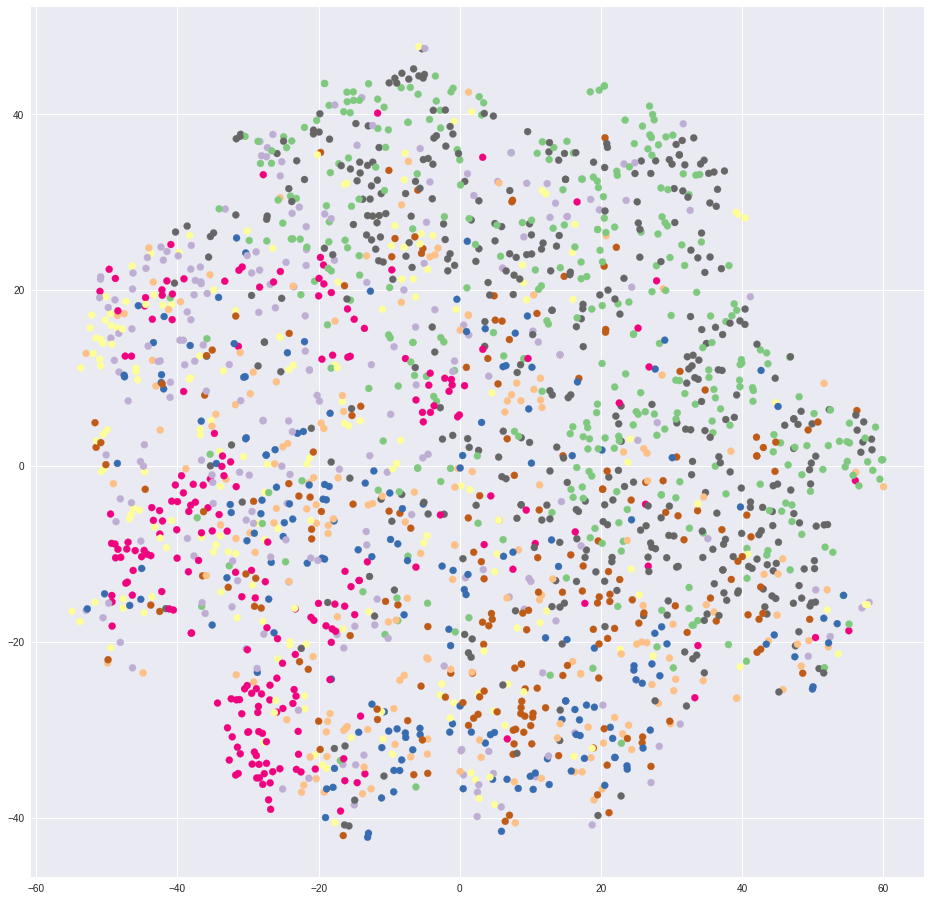

In [50]:
%%time
vis_tsne(feats_train2, y_train)

Again, some clusters are nicely separated (e.g. pink, green) but other are heavily scattered across the space (eg. yellow, blue).

In [0]:
clf2 = LinearSVC()

In [52]:
%%time
clf2.fit(feats_train2, y_train)

CPU times: user 44min 39s, sys: 23.6 s, total: 45min 3s
Wall time: 44min 6s


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [53]:
clf2.score(feats_test2, y_test)

0.7058

Best score so far.

### 4.3 Zero-padded images, model with FC layers

Again we'll use VGG16, but now instead of upsampling, we'll pad 32x32 image with 0s up to the 224x224 resolution. We need to add (224 - 32) / 2 = **96** rows/columns on each side of the original image.

In [0]:
vgg_model = VGG16(weights='imagenet')

In [0]:
sub_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.get_layer('fc2').output)

input_layer = Input(shape=(32, 32, 3))
x = ZeroPadding2D((96, 96))(input_layer)
x = sub_model(x)

model3 = Model(inputs=input_layer, outputs=x)

In [56]:
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 224, 224, 3)       0         
_________________________________________________________________
model_4 (Model)              (None, 4096)              134260544 
Total params: 134,260,544
Trainable params: 134,260,544
Non-trainable params: 0
_________________________________________________________________


In [0]:
model3.compile(optimizer='adam', loss='categorical_crossentropy')

In [58]:
feats_train3 = model3.predict_generator(input_train, verbose=1, steps=1000)

1000/1000 [==============================] - 556s 556ms/step


In [59]:
feats_test3 = model3.predict_generator(input_test, verbose=1, steps=200)

200/200 [==============================] - 111s 556ms/step


In [60]:
feats_train3.shape, feats_test3.shape

((50000, 4096), (10000, 4096))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.284s...
[t-SNE] Computed neighbors for 2000 samples in 33.438s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.440256
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.513664
[t-SNE] Error after 1000 iterations: 1.815781
CPU times: user 1min 15s, sys: 26.8 s, total: 1min 41s
Wall time: 1min 39s


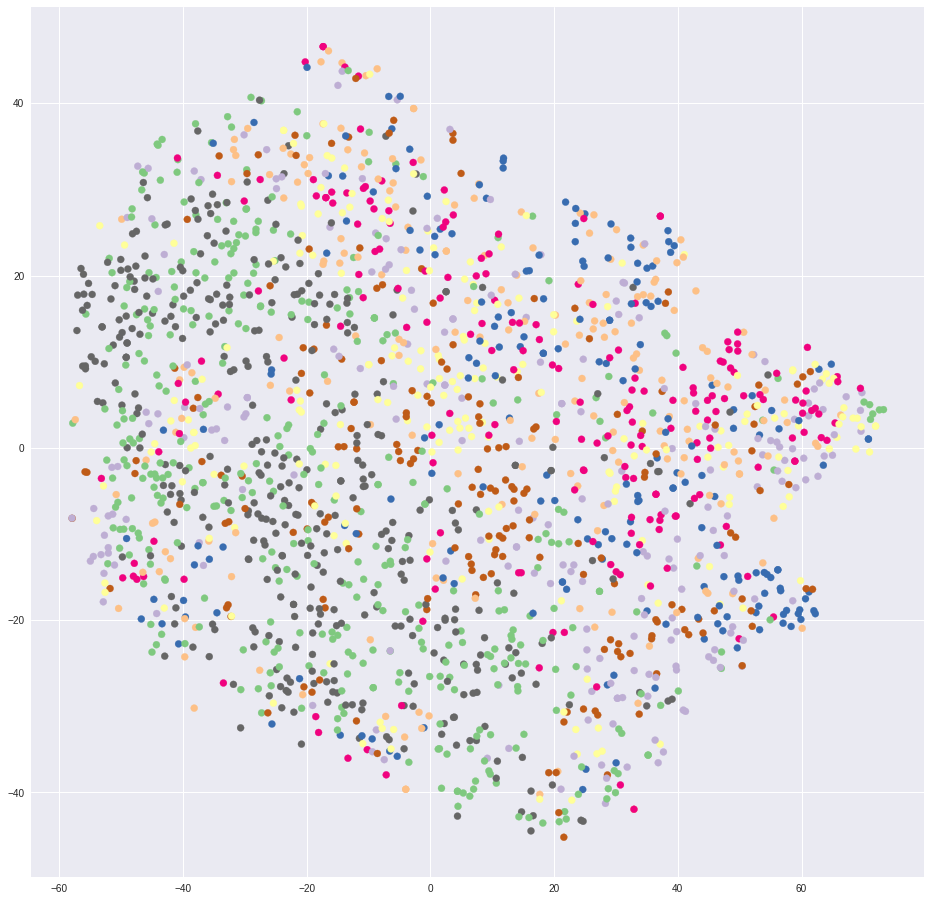

In [79]:
%%time
vis_tsne(feats_train3, y_train)

In [0]:
clf3 = LinearSVC()

In [63]:
%%time
clf3.fit(feats_train3, y_train)

CPU times: user 49min 25s, sys: 32 s, total: 49min 57s
Wall time: 48min 52s


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [64]:
clf3.score(feats_test3, y_test)

0.4822

Score close to baseline.

### 4.4 Upsampled images, factor 2, no FC layers

Let's change approach a bit: let's use acceptable by VGG16 resolution of 64x64 and upsample twofold image. Image modification will not be so severe and we're in the safe zone with resolution. We will however skip FC layers and use pooling at the end of convolutional base.

In [0]:
vgg_model = VGG16(weights='imagenet', input_shape=(64, 64, 3), include_top=False)

In [0]:
input_layer = Input(shape=(32, 32, 3))
x = UpSampling2D((2, 2))(input_layer)
x = vgg_model(x)
x = GlobalMaxPooling2D()(x)

model4 = Model(inputs=input_layer, outputs=x)

In [68]:
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 64, 64, 3)         0         
_________________________________________________________________
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 512)               0         
Total params: 14,714,688
Trainable params: 14,714,688
Non-trainable params: 0
_________________________________________________________________


In [0]:
model4.compile(optimizer='adam', loss='categorical_crossentropy')

In [70]:
feats_train4 = model4.predict_generator(input_train, verbose=1, steps=1000)

1000/1000 [==============================] - 60s 60ms/step


In [71]:
feats_test4 = model4.predict_generator(input_test, verbose=1, steps=200)

200/200 [==============================] - 12s 60ms/step


In [72]:
feats_train4.shape, feats_test4.shape

((50000, 512), (10000, 512))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.038s...
[t-SNE] Computed neighbors for 2000 samples in 4.009s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 1.891804
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.443352
[t-SNE] Error after 1000 iterations: 2.028801
CPU times: user 48.1 s, sys: 26.6 s, total: 1min 14s
Wall time: 1min 13s


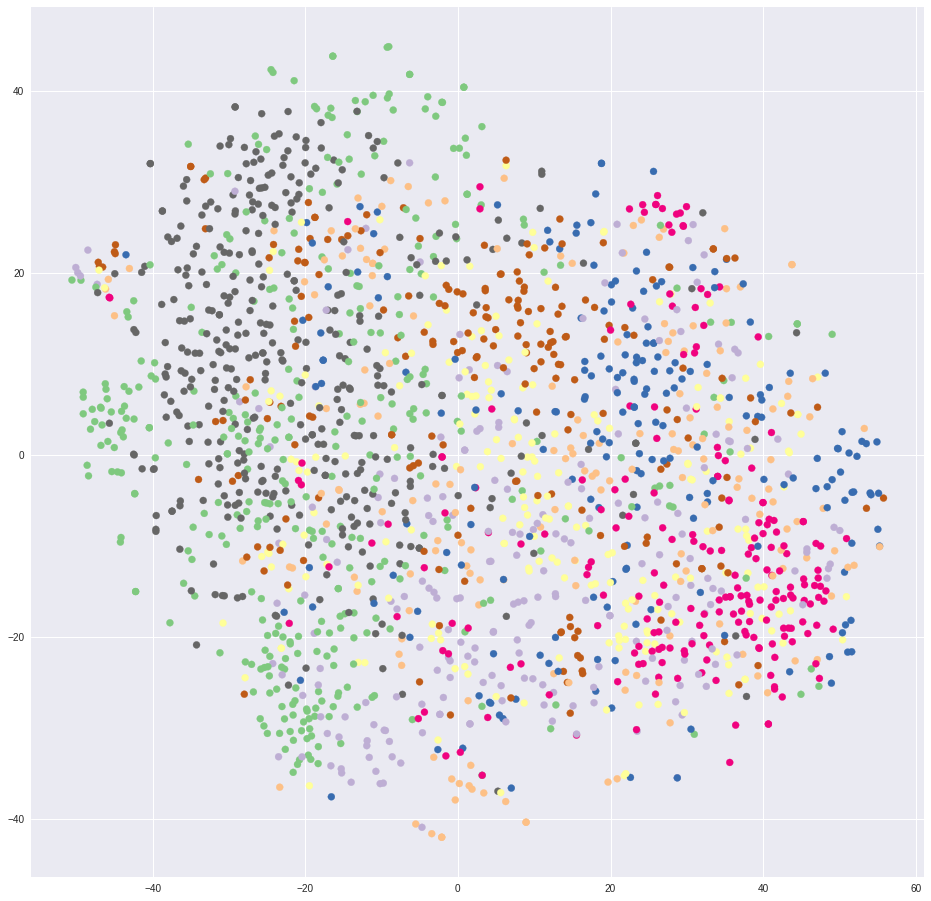

In [73]:
%%time
vis_tsne(feats_train4, y_train)

In [0]:
clf4 = LinearSVC()

In [76]:
%%time
clf4.fit(feats_train4, y_train)

CPU times: user 5min 15s, sys: 3.61 s, total: 5min 18s
Wall time: 5min 12s


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [77]:
clf4.score(feats_test4, y_test)

0.6784

Again, pretty good score, but we've seen better.

### 4.5 InceptionV3, pruned

Here for the first time we'll use InceptionV3 architecture without top FC layers, with max pooling at the end. However, since this is powerful and deep architecture, it quickly becomes unusable due to difference in input sizes (32x32 vs. 224x224). To fix that, we will cut InceptionV3 somewhere in the middle, after one of the concatenation layers (`mixedX`).

In [80]:
inc = InceptionV3(include_top=False, pooling='max', weights='imagenet')

87916544/87910968 [==============================] - 2s 0us/step


In [0]:
x_train_pp = inception_v3.preprocess_input(x_train.astype('float32'))
x_test_pp = inception_v3.preprocess_input(x_test.astype('float32'))

In [0]:
input_train = image_gen.flow(x_train_pp, y_train, batch_size=BATCH_SIZE, shuffle=False)
input_test = image_gen.flow(x_test_pp, y_test, batch_size=BATCH_SIZE, shuffle=False)

In [0]:
submodel_inc = Model(inputs=inc.input, outputs=inc.get_layer('mixed2').output)

input_layer = Input(shape=(32, 32, 3))
x = submodel_inc(input_layer)
x = GlobalMaxPooling2D()(x)

model_inc = Model(inputs=input_layer, outputs=x)

In [84]:
model_inc.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
model_7 (Model)              multiple                  993056    
_________________________________________________________________
global_max_pooling2d_3 (Glob (None, 288)               0         
Total params: 993,056
Trainable params: 989,344
Non-trainable params: 3,712
_________________________________________________________________


In [85]:
feats_train_inc = model_inc.predict_generator(input_train, verbose=1, steps=1000)

1000/1000 [==============================] - 15s 15ms/step


In [86]:
feats_test_inc = model_inc.predict_generator(input_test, verbose=1, steps=200)

200/200 [==============================] - 3s 14ms/step


In [87]:
feats_train_inc.shape, feats_test_inc.shape

((50000, 288), (10000, 288))

In [0]:
clf_inc = LinearSVC()

In [89]:
%%time
clf_inc.fit(feats_train_inc, y_train)

CPU times: user 8min 19s, sys: 4.28 s, total: 8min 23s
Wall time: 8min 13s


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [90]:
clf_inc.score(feats_test_inc, y_test)

0.1003

This score suggest that the noise is so big, that it actually does look like random choice of label - if we set all the labels to single label, and assume 10 labels with balanced numbers, we will achieve 10% accuracy.

## 6. Tune best classifier

We have tested several classifiers by now. Now it's time to pick the best one and try to adjust hyperparameters to further improve the model. We're going to use second model (70% accuracy).

Note `loss_penalty_dual` parameter below: for `sklearn.svm.LinearSVC()` not all parameters can occur together - eg. `hinge` loss can only have `l2` penalty and `dual` parameter set to `True`.

In [0]:
search_space = {
    'C': hp.loguniform('C', np.log(1e-5), np.log(1e5)),
    'loss_penalty_dual': \
    hp.choice('loss_penalty_dual', [
        ('hinge', 'l2', True),
        ('squared_hinge', 'l2', True),
        ('squared_hinge', 'l1', False),
        ('squared_hinge', 'l2', False)
    ]),
    'tol': hp.loguniform("tol", np.log(1e-5), np.log(1e-2)),
    'multi_class': hp.choice("multi_class", ['ovr', 'crammer_singer']),
}

In [0]:
def objective(space, X, y):
    print('.', end='', flush=True) # poor man's progress bar
    space['loss'], space['penalty'], space['dual'] = space['loss_penalty_dual']
    del space['loss_penalty_dual']
    
    clf = LinearSVC(**space)
    
    x_hopt_train, x_hopt_test, y_hopt_train, y_hopt_test = train_test_split(X, y, stratify=y_train, test_size=5000)
        
    clf.fit(x_hopt_train, y_hopt_train)
    y_pred = clf.predict(x_hopt_test)
    acc = accuracy_score(y_hopt_test, y_pred)
    
    return {'status': STATUS_OK, 
            'loss': 1 - acc,
            'params': clf.get_params()}

We will run 10 different parameter sets. The number should be higher, but not too high (I'd say no more that 30), because we might overfit on validation dataset. For the sake of time, we will keep it small at 10.

In [0]:
%%time

clf_trials = Trials()
best = fmin(fn=lambda params: objective(params, feats_train2, y_train),
            space=search_space,
            algo=tpe.suggest,
            max_evals=10,
            trials=clf_trials,
            verbose=1)

..

Following parameters are the best of all runs

In [0]:
params = space_eval(search_space, best)
print(params)

Building parameters for final classifier

In [0]:
params['loss'], params['penalty'], params['dual'] = params['loss_penalty_dual']
del params['loss_penalty_dual']

Training final classifier

In [0]:
clf_final = LinearSVC(**params)

In [0]:
%%time
clf_final.fit(feats_train2, y_train)

In [0]:
clf_final.score(feats_train2, y_test)

## Summary and next steps

It looks like major problem in this task is size of input image. Best model upsamples input image to the full size of original architecture's input.

Intuitively however, upsampled image instead of small pixels will have big 7x7 pixels which will look for pretrained network more like square blobs rather than shapes it expects.

Few other ideas worth exploring would be mixing methods previously used: upsampling, pruning network, zero padding.


In the end, I would not use on top of that any of the "standard" ML models like SVM/trees/random forests/boosted trees even with ensembling. Reason behind this is that I believe that few FC layers trained with convolutional base transferred from other model will have the same effect and will probably be easier to train end-to-end, with all the goodness of transfer learning like augmentation, fine-tuning. After all ensembling's major goal is to introduce nonlinearity, but that what FC layers with activation functions do.